In [1]:
cd ../..

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans


In [35]:
import numpy as np
import pandas as pd
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from gans.utils import create_gan, train_gan
from utils.windowing import windowing_dataframe, transform_windows_df
from utils.preprocess import filter_by_activity_index, calc_consultant
from utils.plotting import plot_n_heatmaps, plot_n_lineplots
import seaborn as sns

In [36]:
def create_discriminator(input_shape, optimizer=Adam(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)):
    discriminator = Sequential()
    discriminator.add(LSTM(5, activation='relu', return_sequences=True, input_shape=input_shape))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator

In [38]:
def create_generator(latent_dim, small=True):
    if small:
        generator = Sequential()
        generator.add(Dense(window_size, kernel_initializer='he_uniform', input_shape=(latent_dim, )))
        generator.add(LeakyReLU())
        generator.add(Reshape((window_size, 1)))
        generator.add(LSTM(6, return_sequences=True, kernel_initializer='he_uniform'))
        generator.add(LeakyReLU())
        generator.add(LSTM(3, return_sequences=True, kernel_initializer='he_uniform', activation='linear'))
    else:
        generator = Sequential()
        generator.add(Dense(window_size, kernel_initializer='he_uniform', input_shape=(latent_dim, )))
        generator.add(LeakyReLU())
        generator.add(Reshape((window_size, 1)))
        generator.add(LSTM(12, return_sequences=True, kernel_initializer='he_uniform'))
        generator.add(LeakyReLU())
        generator.add(LSTM(9, return_sequences=True, kernel_initializer='he_uniform'))
        generator.add(LeakyReLU())
        generator.add(LSTM(6, return_sequences=True, kernel_initializer='he_uniform'))
        generator.add(LeakyReLU())
        generator.add(LSTM(3, return_sequences=True, kernel_initializer='he_uniform', activation='linear'))
    
    return generator

In [39]:
generator.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 250)               32250     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 250)               0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 250, 1)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 250, 6)            192       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 250, 6)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 250, 3)            120       
Total params: 32,562
Trainable params: 32,562
Non-trainable params: 0
_________________________________________________

In [5]:
act_id = 0

latent_dim = 64
steps = 1000
batch_size = 32

num_gen = 1000
add_sample_num = 500

In [6]:
train_df = pd.read_hdf('./datasets/mydata/train_df.h5')
val_df = pd.read_hdf('./datasets/mydata/val_df.h5')
test_df = pd.read_hdf('./datasets/mydata/test_df.h5')

In [7]:
window_size = 5*50
step_size = int(window_size/2)
col_names = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'userAcceleration.c']
method ='sliding'

In [8]:
train_windowed_df = windowing_dataframe(train_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
val_windowed_df = windowing_dataframe(val_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
test_windowed_df = windowing_dataframe(test_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

In [9]:
input_cols = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [10]:
x_train_activity, _ = filter_by_activity_index(x=x_train, y=y_train, activity_idx=act_id)

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
labels=["standing", "waldking", "jogging"]

In [12]:
input_cols = ['userAcceleration.c']
x_train_clf, y_train_clf = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val_clf, y_val_clf = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test_clf, y_test_clf = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [13]:
x_train_clf = x_train_clf.reshape((len(x_train_clf), window_size))
x_val_clf = x_val_clf.reshape((len(x_val_clf), window_size))
x_test_clf = x_test_clf.reshape((len(x_test_clf), window_size))

In [14]:
svm_clf = SVC()
svm_clf.fit(x_train_clf, y_train_clf)

SVC()

#### train performance

In [15]:
y_train_head = svm_clf.predict(x_train_clf)
print(classification_report(y_train_clf, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.60      1.00      0.75      1547
    waldking       0.87      0.42      0.57      1810
     jogging       0.99      0.83      0.90       669

    accuracy                           0.71      4026
   macro avg       0.82      0.75      0.74      4026
weighted avg       0.79      0.71      0.69      4026



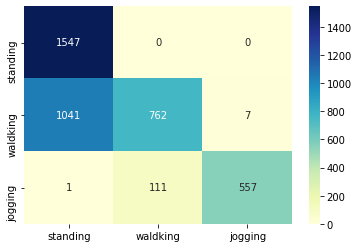

In [16]:
cm = confusion_matrix(y_train_clf, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [17]:
orig_train_acc = accuracy_score(y_train_clf, y_train_head)
orig_train_acc

0.711872826626925

#### test performance

In [18]:
y_test_head = svm_clf.predict(x_test_clf)

In [19]:
print(classification_report(y_test_clf, y_test_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.68      1.00      0.81       403
    waldking       0.77      0.34      0.47       387
     jogging       0.67      0.77      0.72       173

    accuracy                           0.69       963
   macro avg       0.71      0.71      0.67       963
weighted avg       0.72      0.69      0.66       963



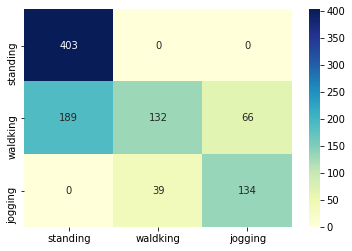

In [20]:
cm = confusion_matrix(y_test, y_test_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [21]:
orig_test_acc = accuracy_score(y_test_clf, y_test_head)
orig_test_acc

0.6947040498442367

In [22]:
### GAN

In [23]:
input_shape = x_train[0].shape
discriminator = create_discriminator(input_shape);
generator = create_generator(latent_dim)
optimizer = Adam(clipvalue=x_train_activity.max())
gan = create_gan(generator_model=generator, discriminator_model=discriminator, optimizer=optimizer)

In [24]:
train_gan(generator, discriminator, gan, x_train_activity, steps)

discriminator loss: [0.6809117794036865, 0.6640625]
adversarial loss: 0.7226076126098633
discriminator loss: [0.7858854532241821, 0.1796875]
adversarial loss: 0.5449491739273071
discriminator loss: [0.3529326915740967, 1.0]
adversarial loss: 2.1400012969970703
discriminator loss: [1.013948678970337, 0.5]
adversarial loss: 0.29440027475357056
discriminator loss: [0.4615764021873474, 0.515625]
adversarial loss: 1.6809898614883423
discriminator loss: [0.9536155462265015, 0.5]
adversarial loss: 0.3365912139415741
discriminator loss: [0.8091753125190735, 0.0703125]
adversarial loss: 0.5411912202835083
discriminator loss: [0.7736184597015381, 0.1640625]
adversarial loss: 0.5711827278137207
discriminator loss: [0.5344789028167725, 1.0]
adversarial loss: 1.0721677541732788
discriminator loss: [0.5775538682937622, 1.0]
adversarial loss: 0.9457067251205444


In [25]:
## eval

In [26]:
random_latent_vectors = np.random.normal(size=(num_gen, latent_dim))
generated_sensor_data = generator.predict(random_latent_vectors)

In [27]:
gen_df = pd.DataFrame(np.array([ts.transpose() for ts in generated_sensor_data]).tolist(), columns= ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'])
gen_df['userAcceleration.c'] = calc_consultant(gen_df)
gen_df['act'] = act_id

In [28]:
gen_windowed_df = windowing_dataframe(gen_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
    
input_cols = ['userAcceleration.c']
x_gen, y_gen = transform_windows_df(gen_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_gen = x_gen.reshape((len(x_gen), window_size))

x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, y_gen[:add_sample_num]])

In [29]:
svm_clf = SVC()
svm_clf.fit(x_train_gen, y_train_gen)
    
y_train_head = svm_clf.predict(x_train_clf)
train_acc = accuracy_score(y_train_clf, y_train_head)
    
y_test_head = svm_clf.predict(x_test_clf)
test_acc = accuracy_score(y_test_clf, y_test_head)

In [30]:
print('Gen Train acc:', train_acc, 'vs.', orig_train_acc, ': Orig Train Acc')
print('Gen Test acc:', test_acc, 'vs.', orig_test_acc, 'Orig Test Acc')

Gen Train acc: 0.7208147044212618 vs. 0.711872826626925 : Orig Train Acc
Gen Test acc: 0.6978193146417445 vs. 0.6947040498442367 Orig Test Acc


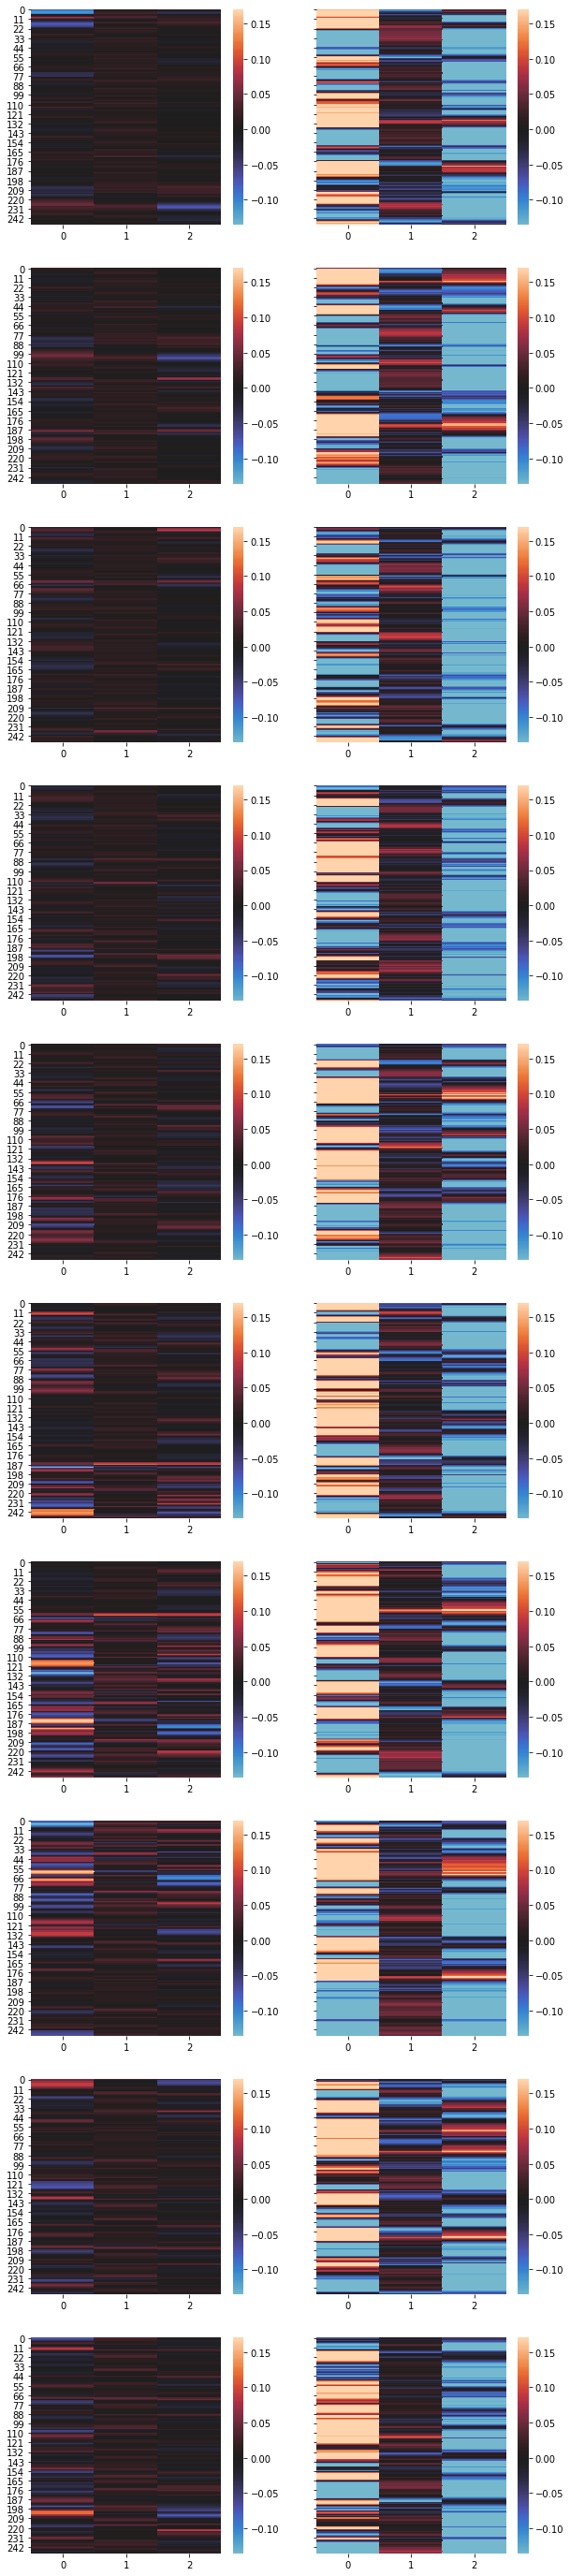

In [31]:
plot_n_heatmaps(x_train_activity, generated_sensor_data, n=10)

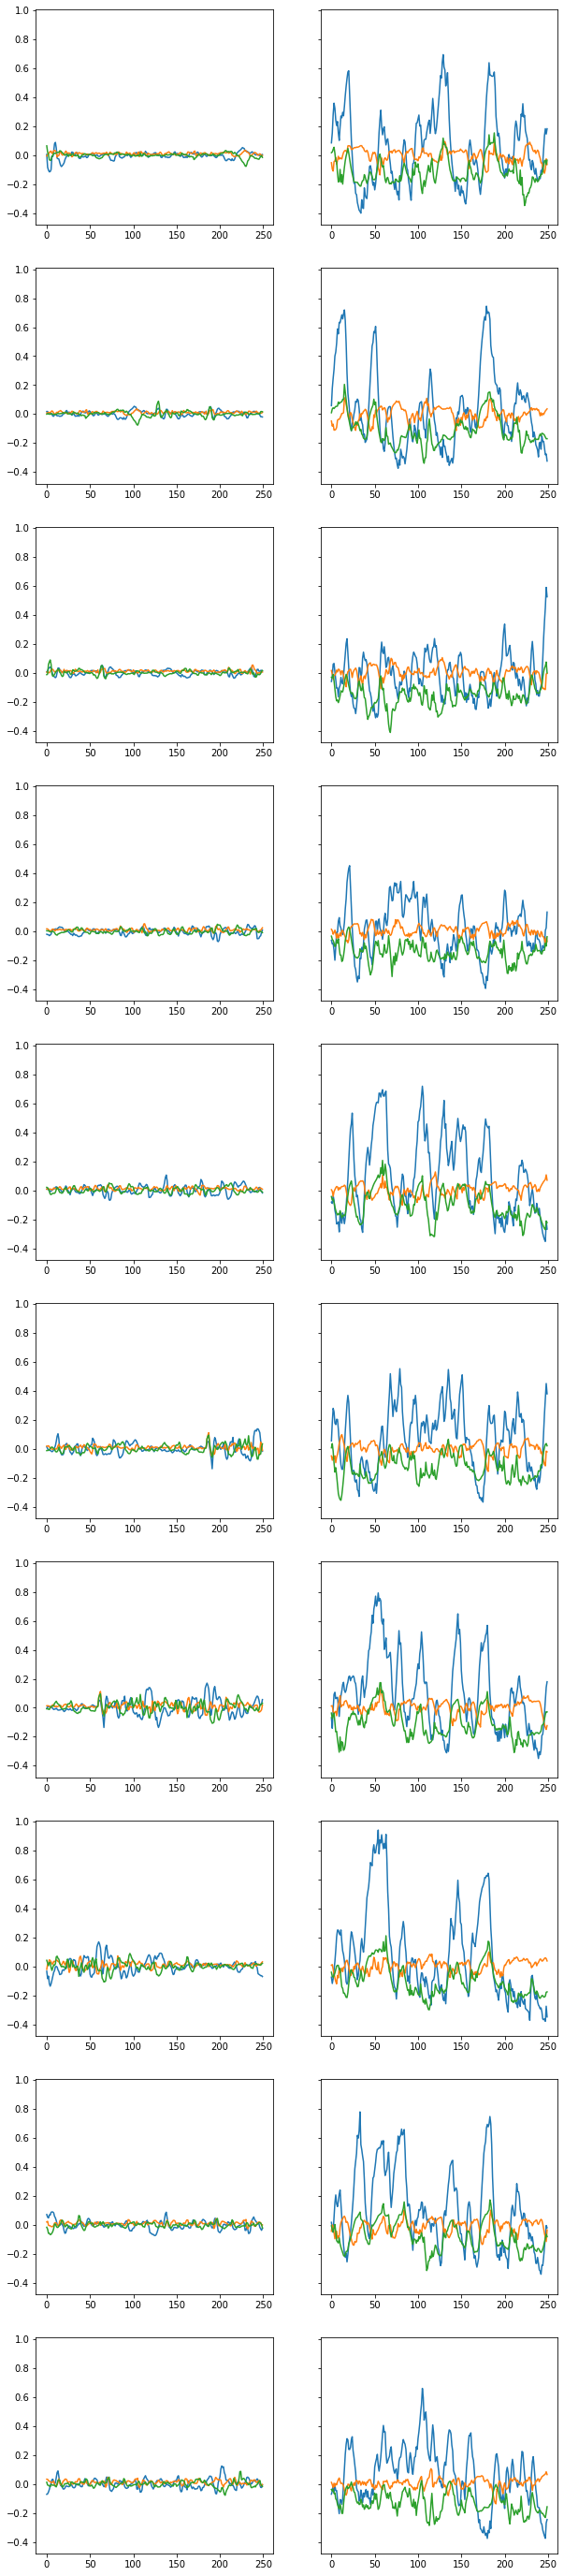

In [32]:
plot_n_lineplots(x_train_activity, generated_sensor_data, n=10)

discriminator loss: [0.6961848139762878, 0.390625]
adversarial loss: 0.6915361881256104
discriminator loss: [0.9548274874687195, 0.296875]
adversarial loss: 0.3656519055366516
discriminator loss: [0.7714670896530151, 0.5]
adversarial loss: 0.4894547462463379
discriminator loss: [0.6562587022781372, 0.515625]
adversarial loss: 0.8065338134765625
discriminator loss: [0.7923216223716736, 0.0]
adversarial loss: 0.5466512441635132
discriminator loss: [0.7074987888336182, 0.4765625]
adversarial loss: 0.6316813230514526
discriminator loss: [0.5750302076339722, 1.0]
adversarial loss: 0.9177255630493164
discriminator loss: [0.9468010663986206, 0.046875]
adversarial loss: 0.3866982161998749
discriminator loss: [0.7512818574905396, 0.375]
adversarial loss: 0.5911029577255249
discriminator loss: [0.8466731309890747, 0.5]
adversarial loss: 0.45623016357421875
discriminator loss: [0.6050008535385132, 0.859375]
adversarial loss: 0.8731933832168579
discriminator loss: [1.0056195259094238, 0.1484375]
a

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

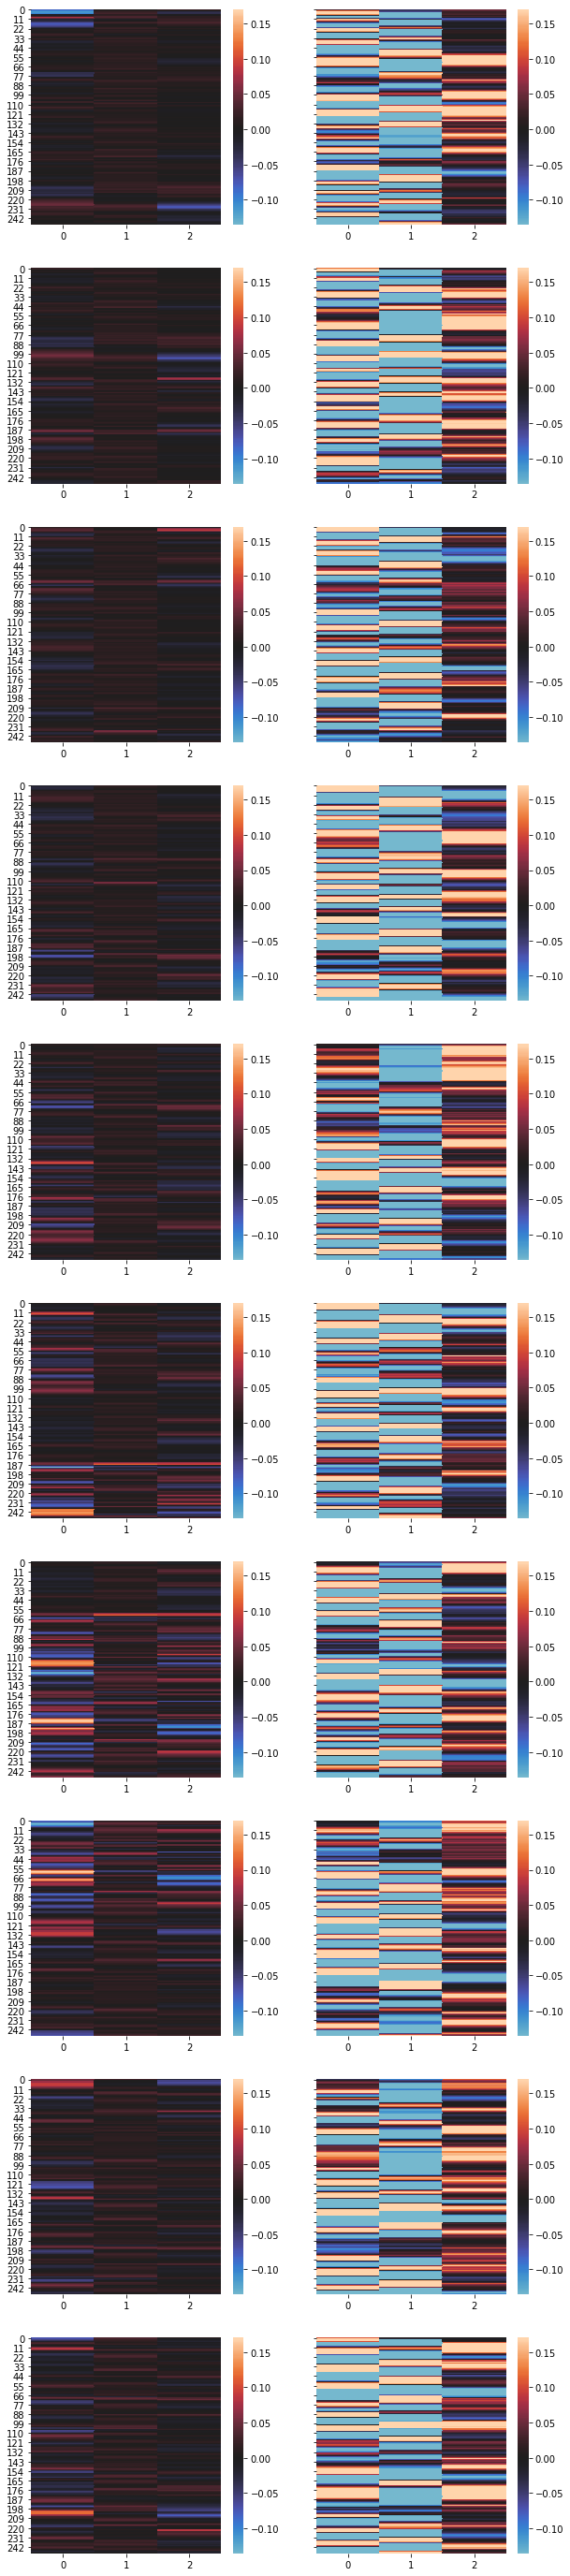

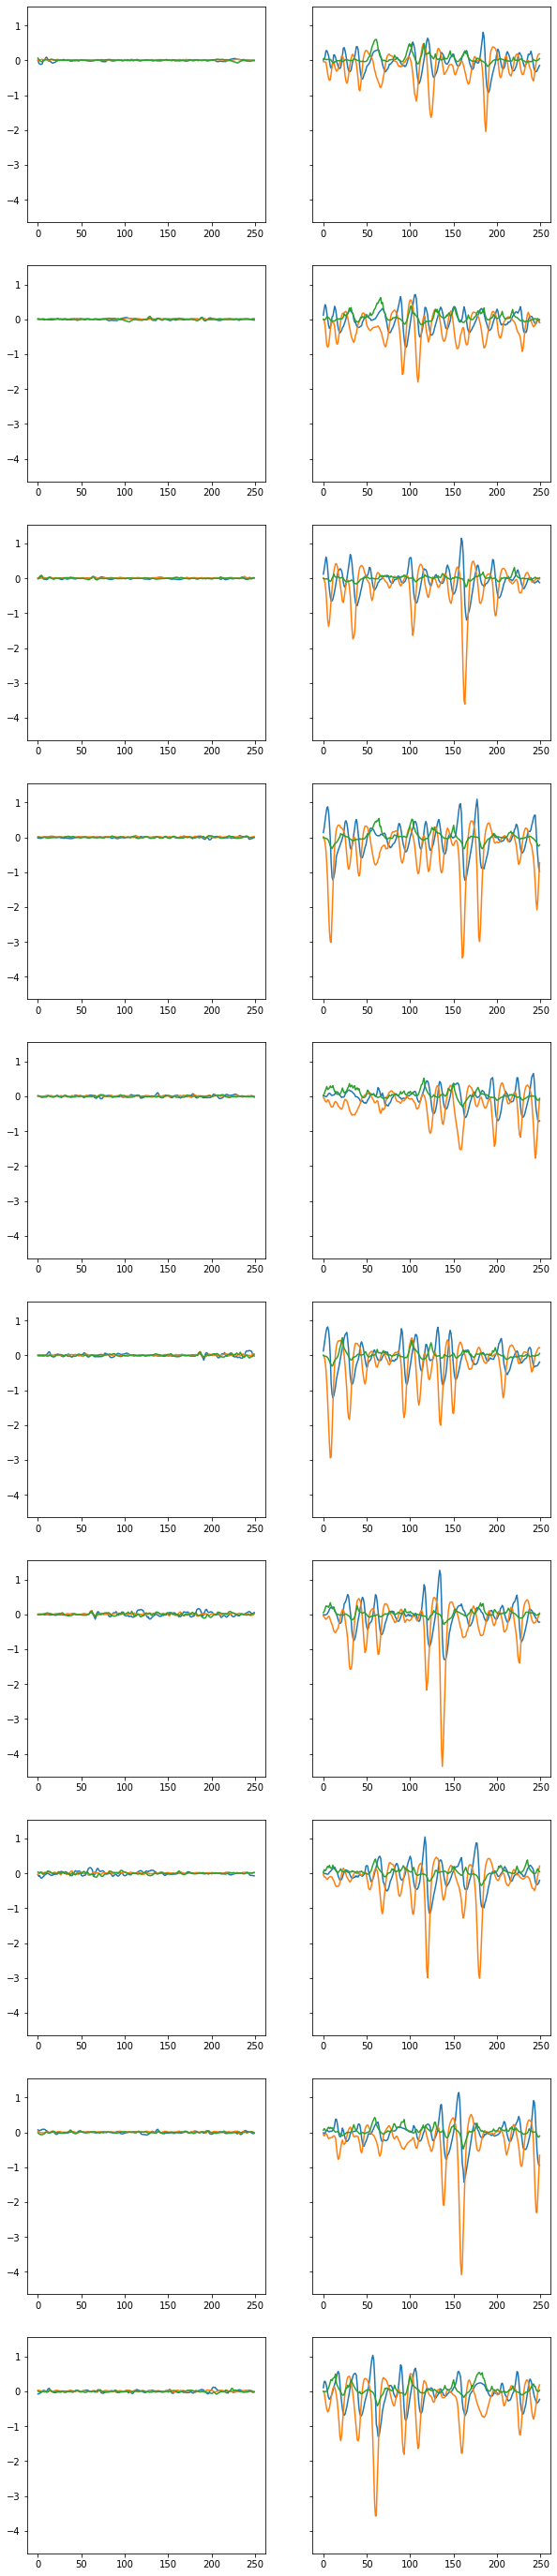

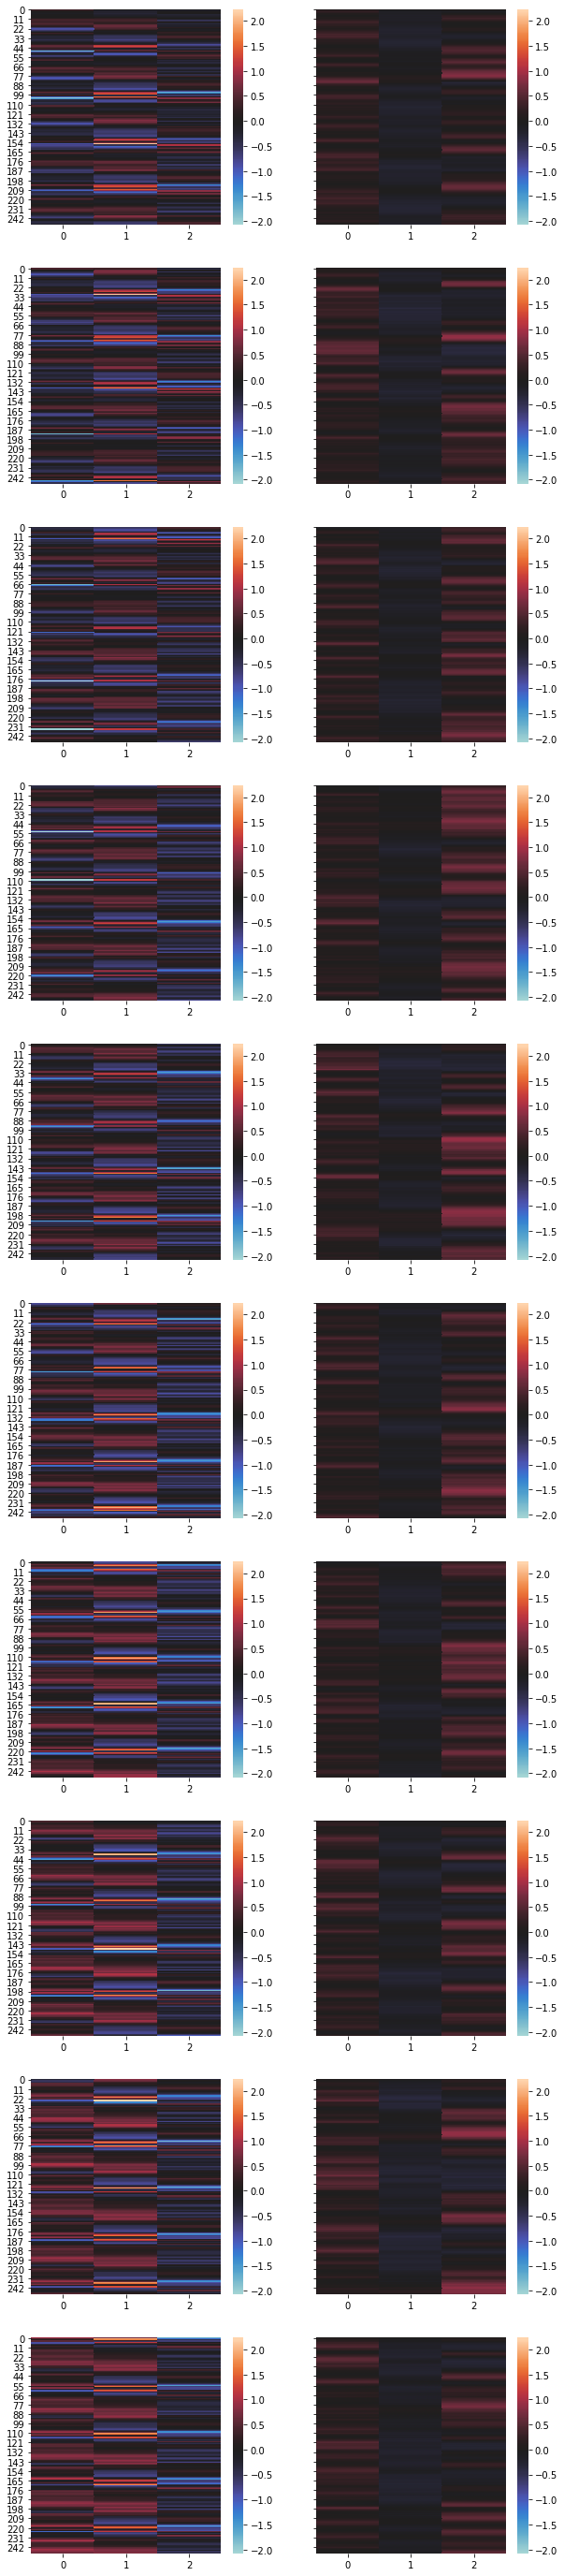

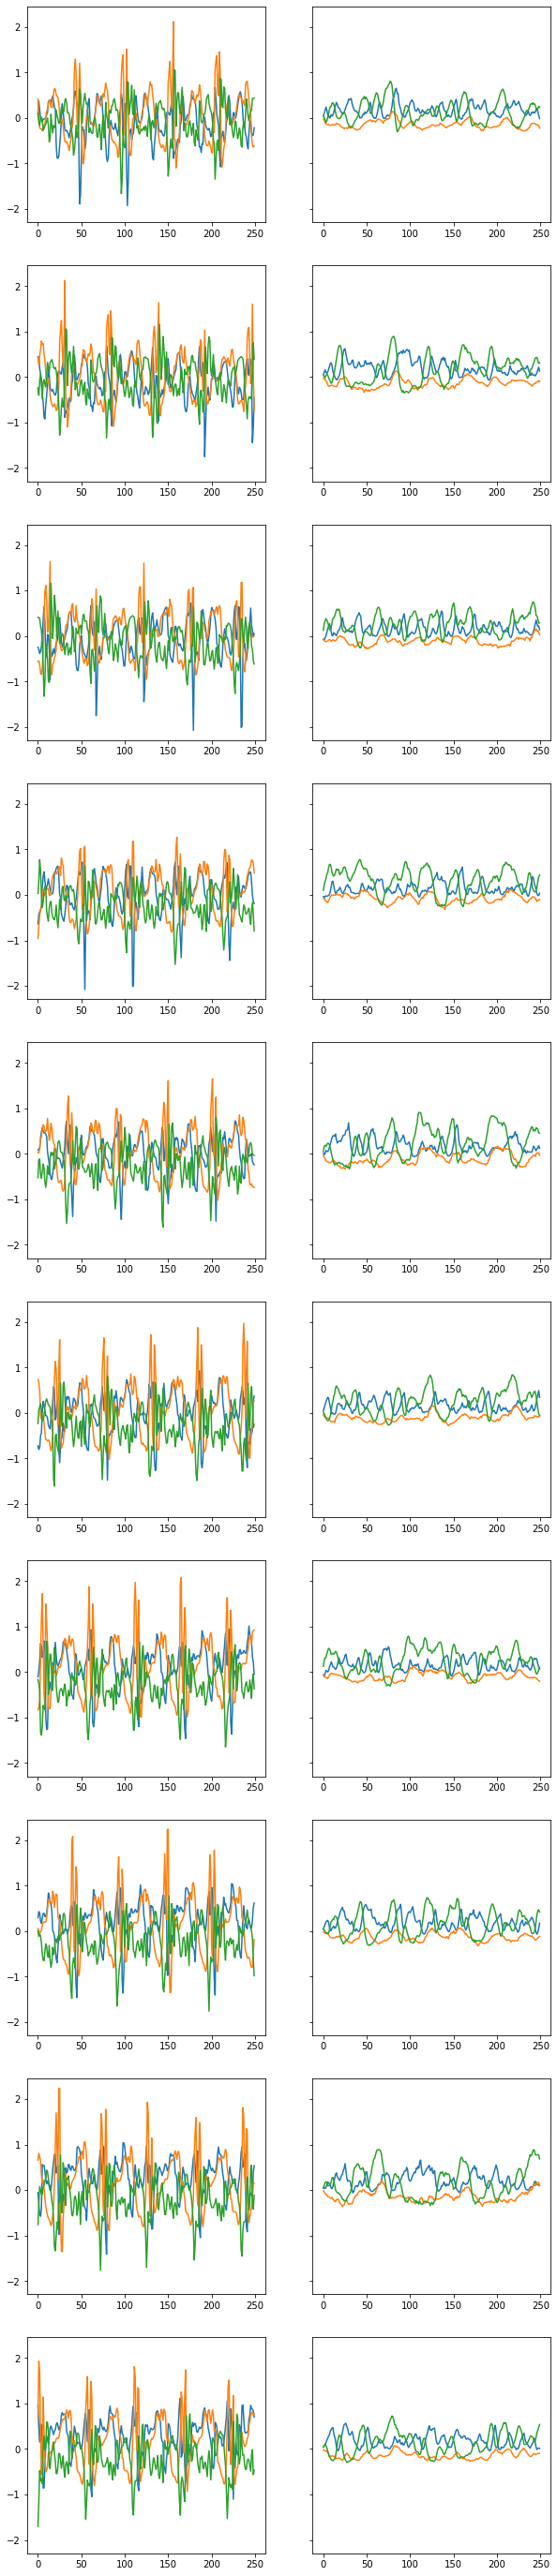

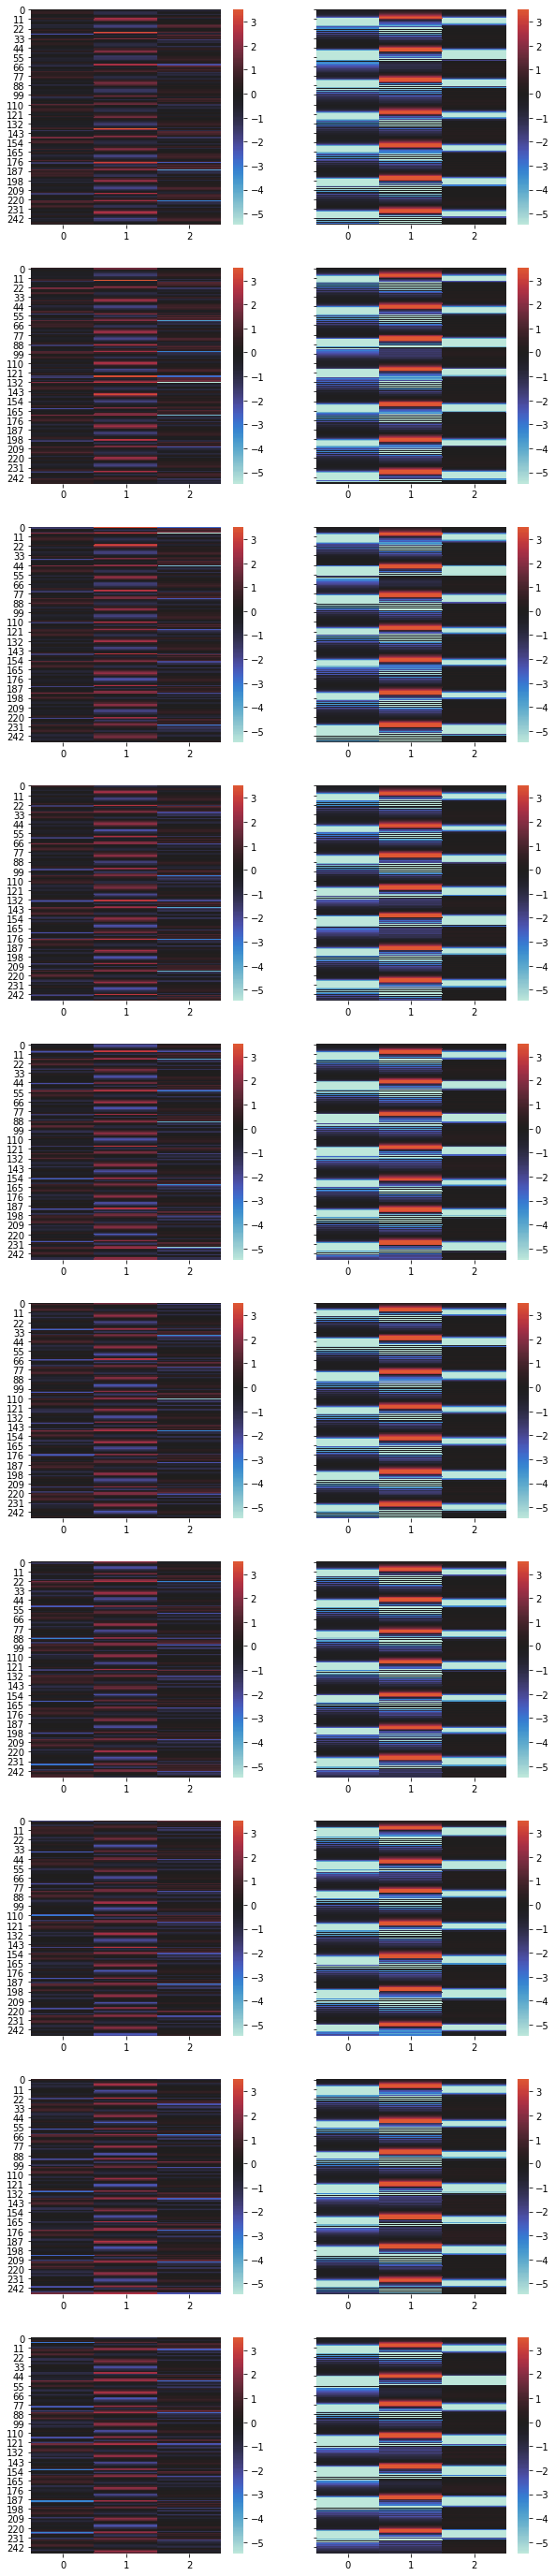

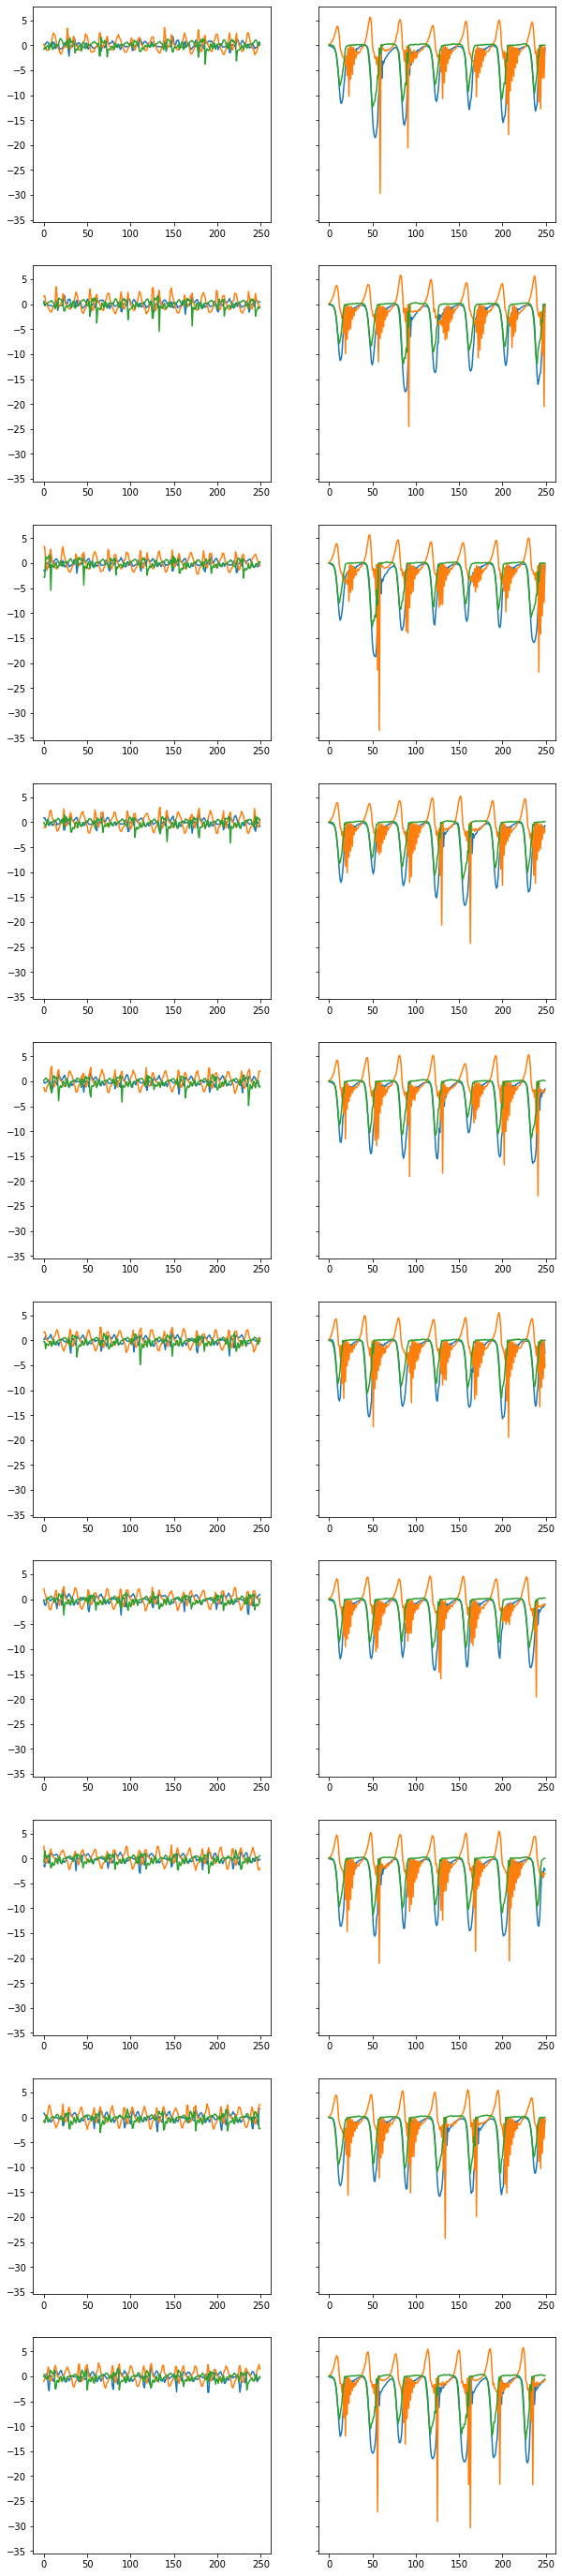

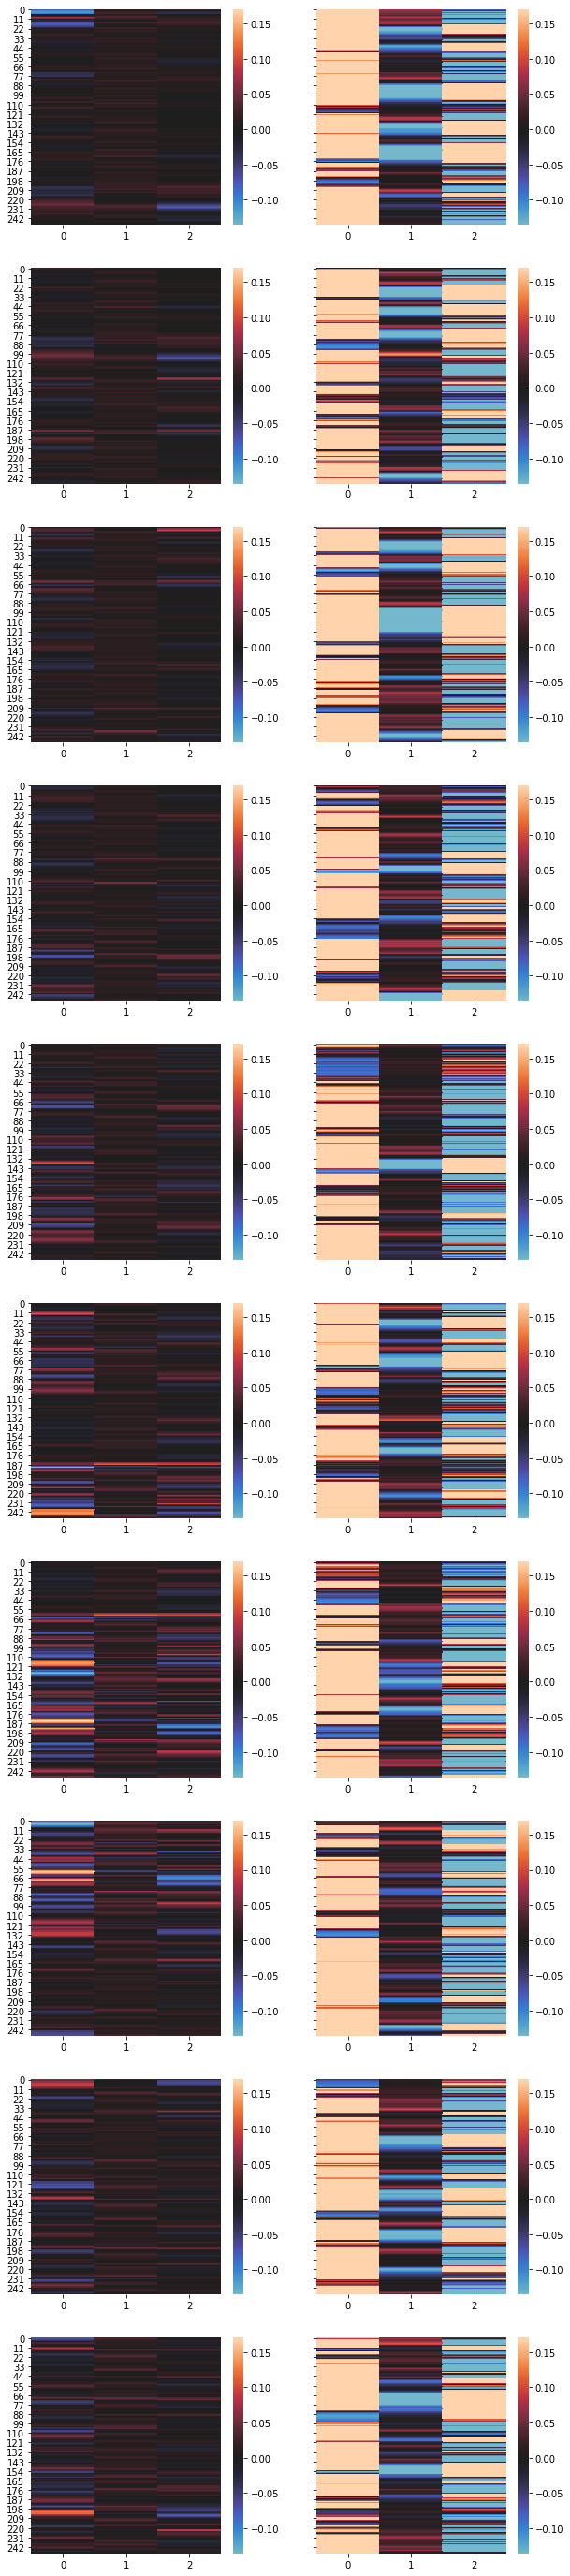

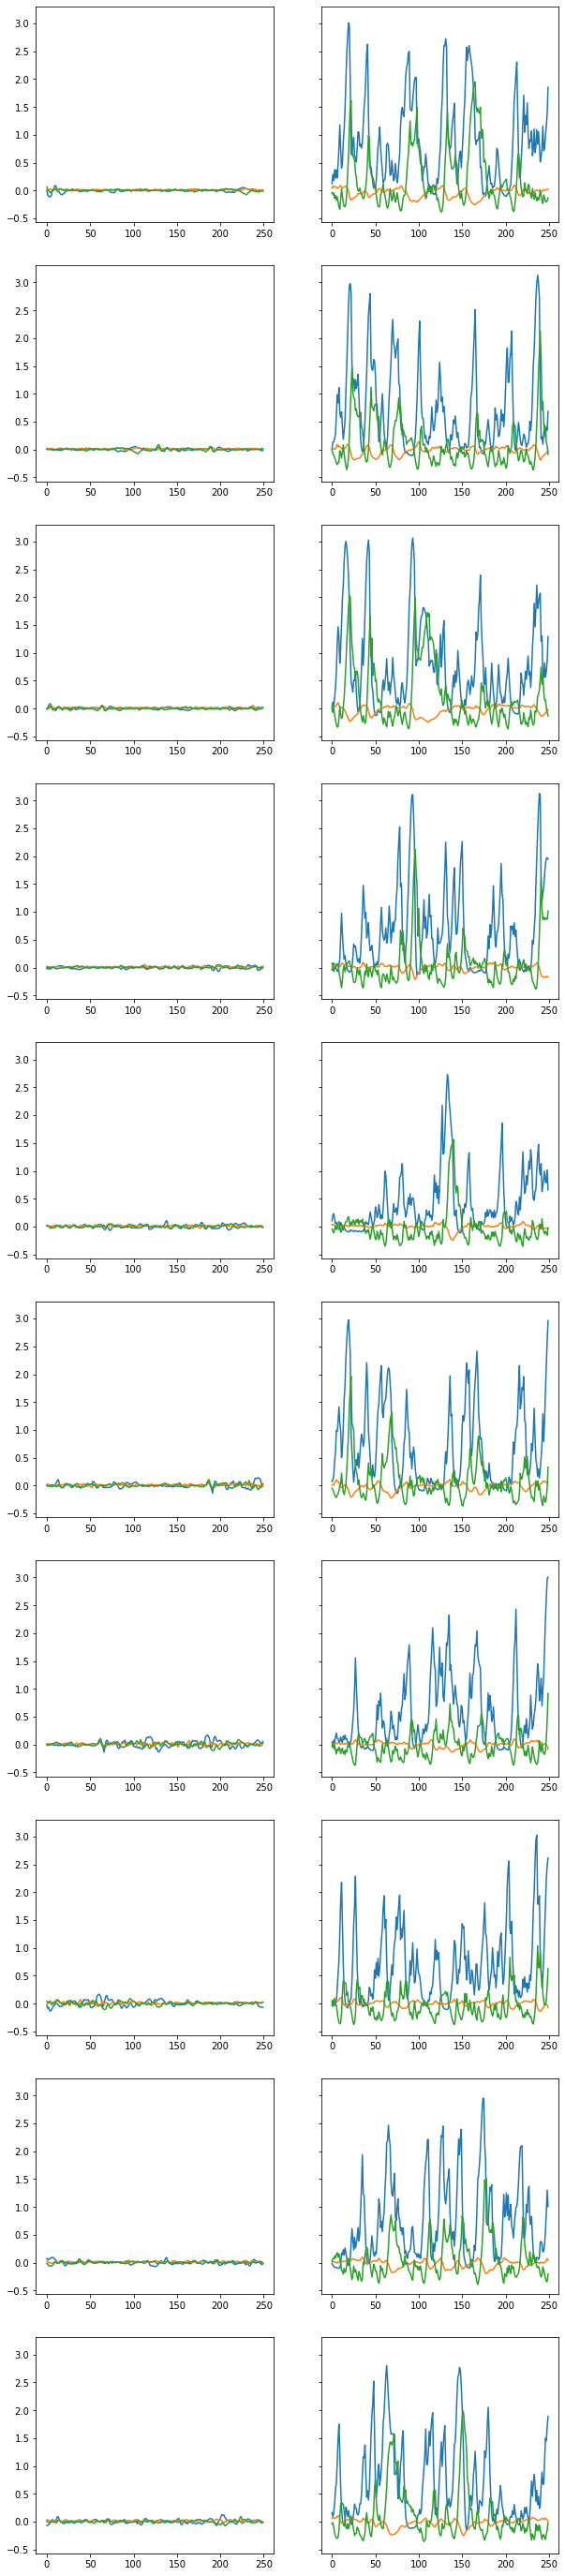

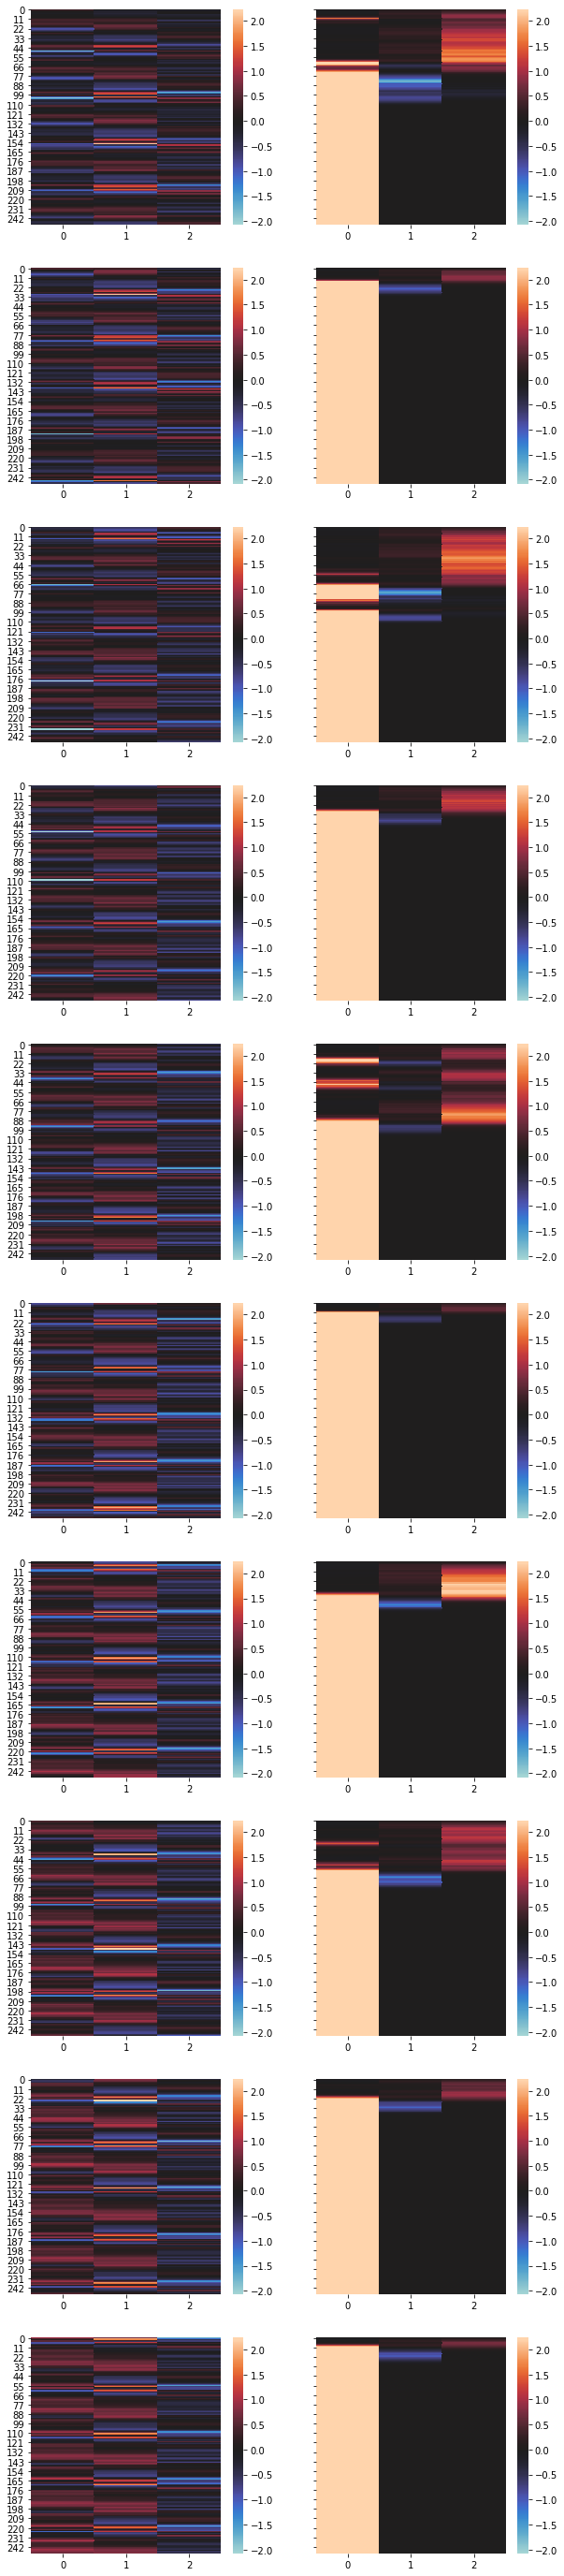

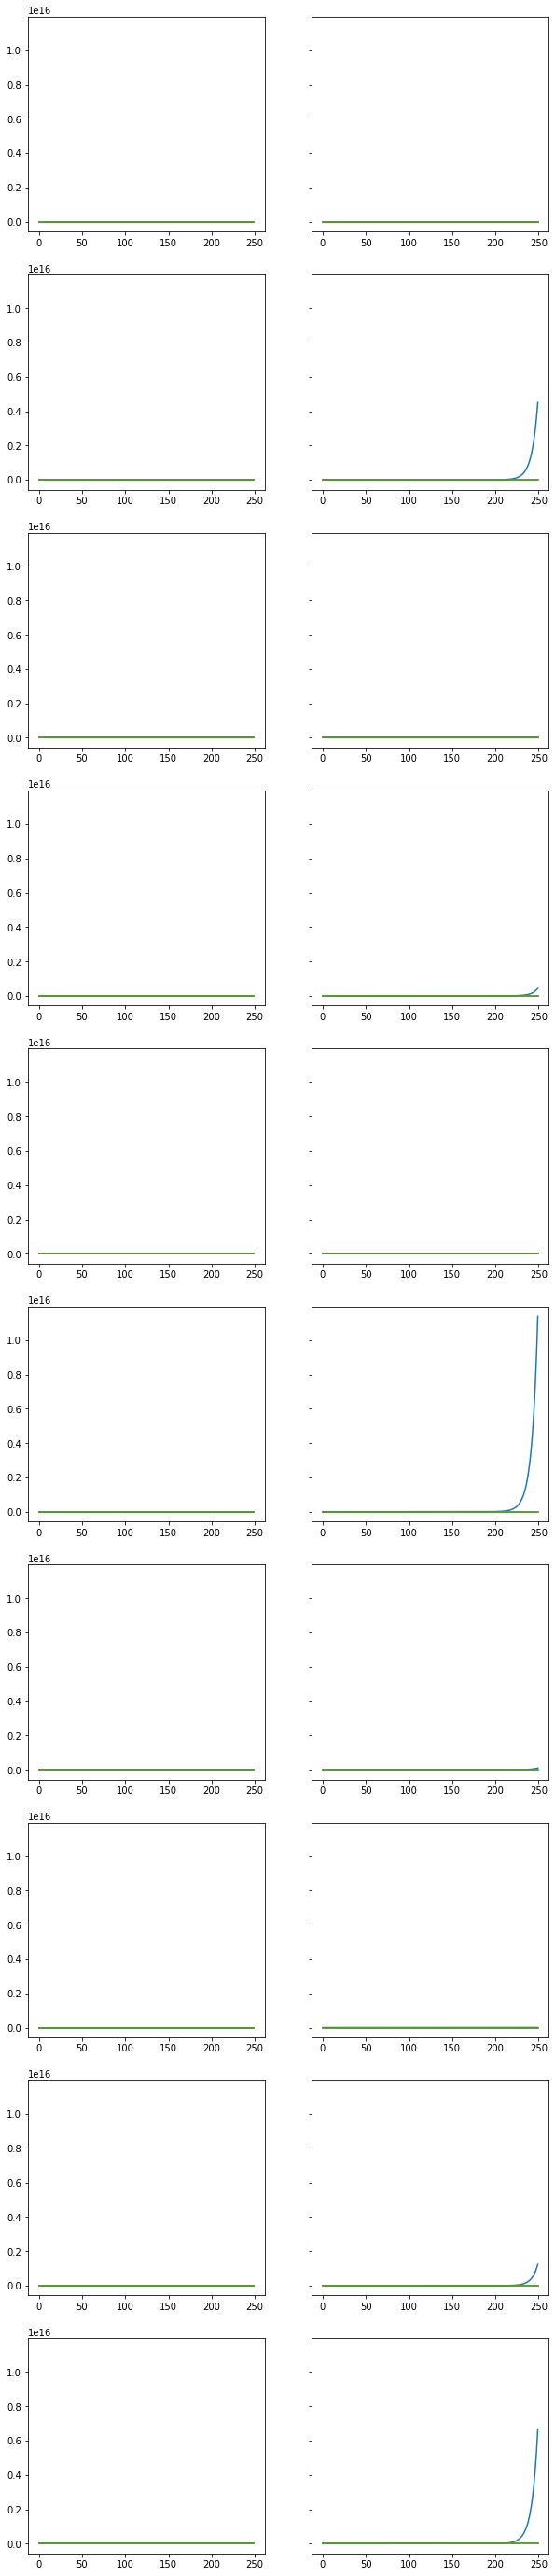

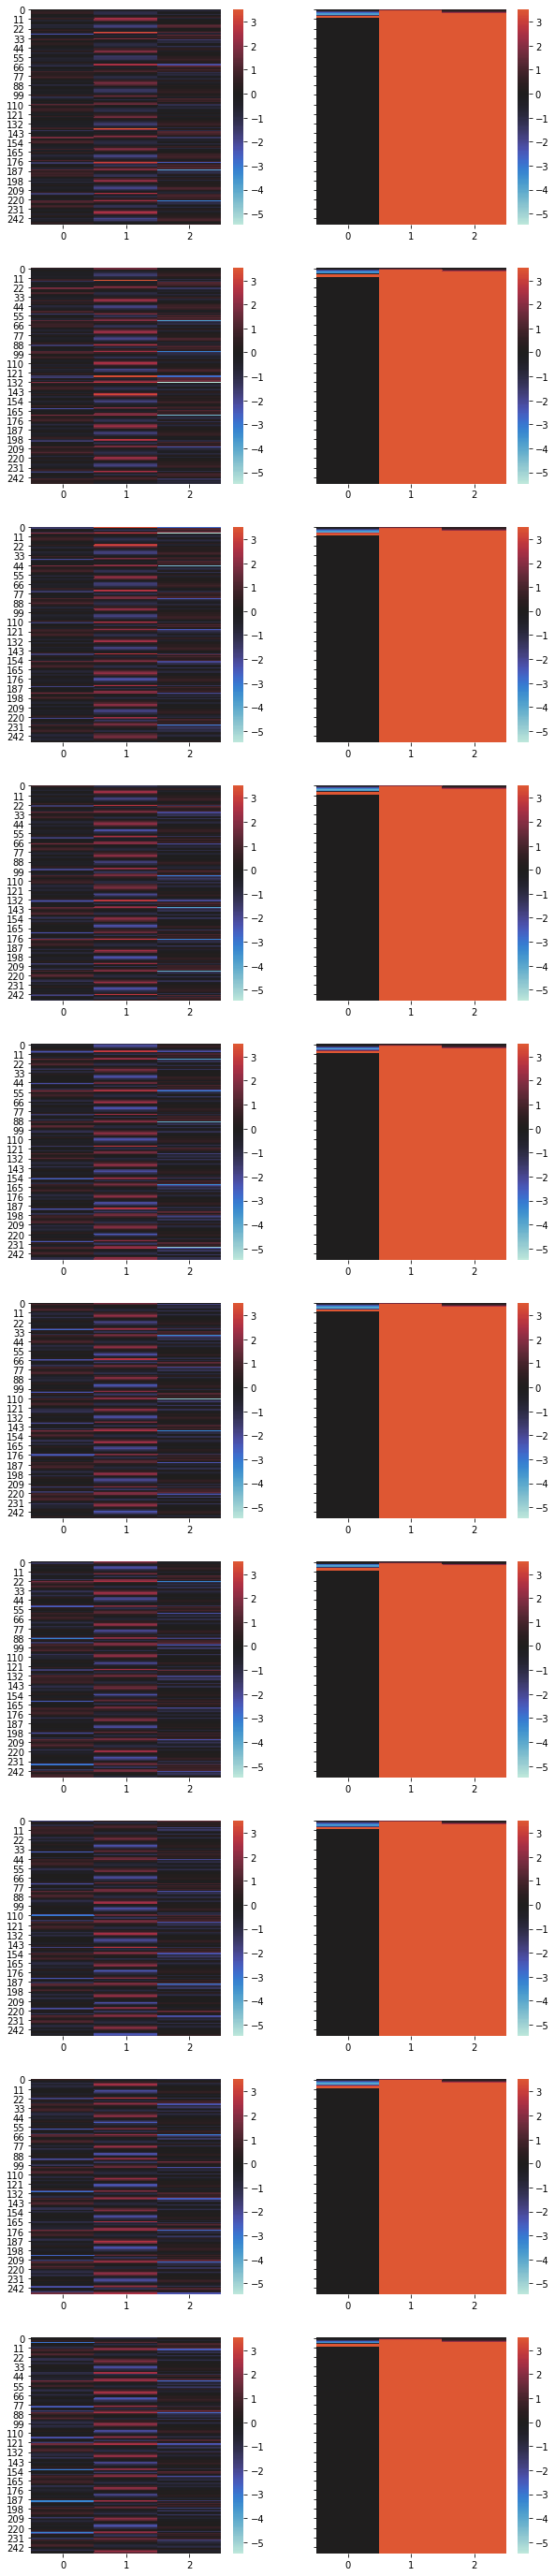

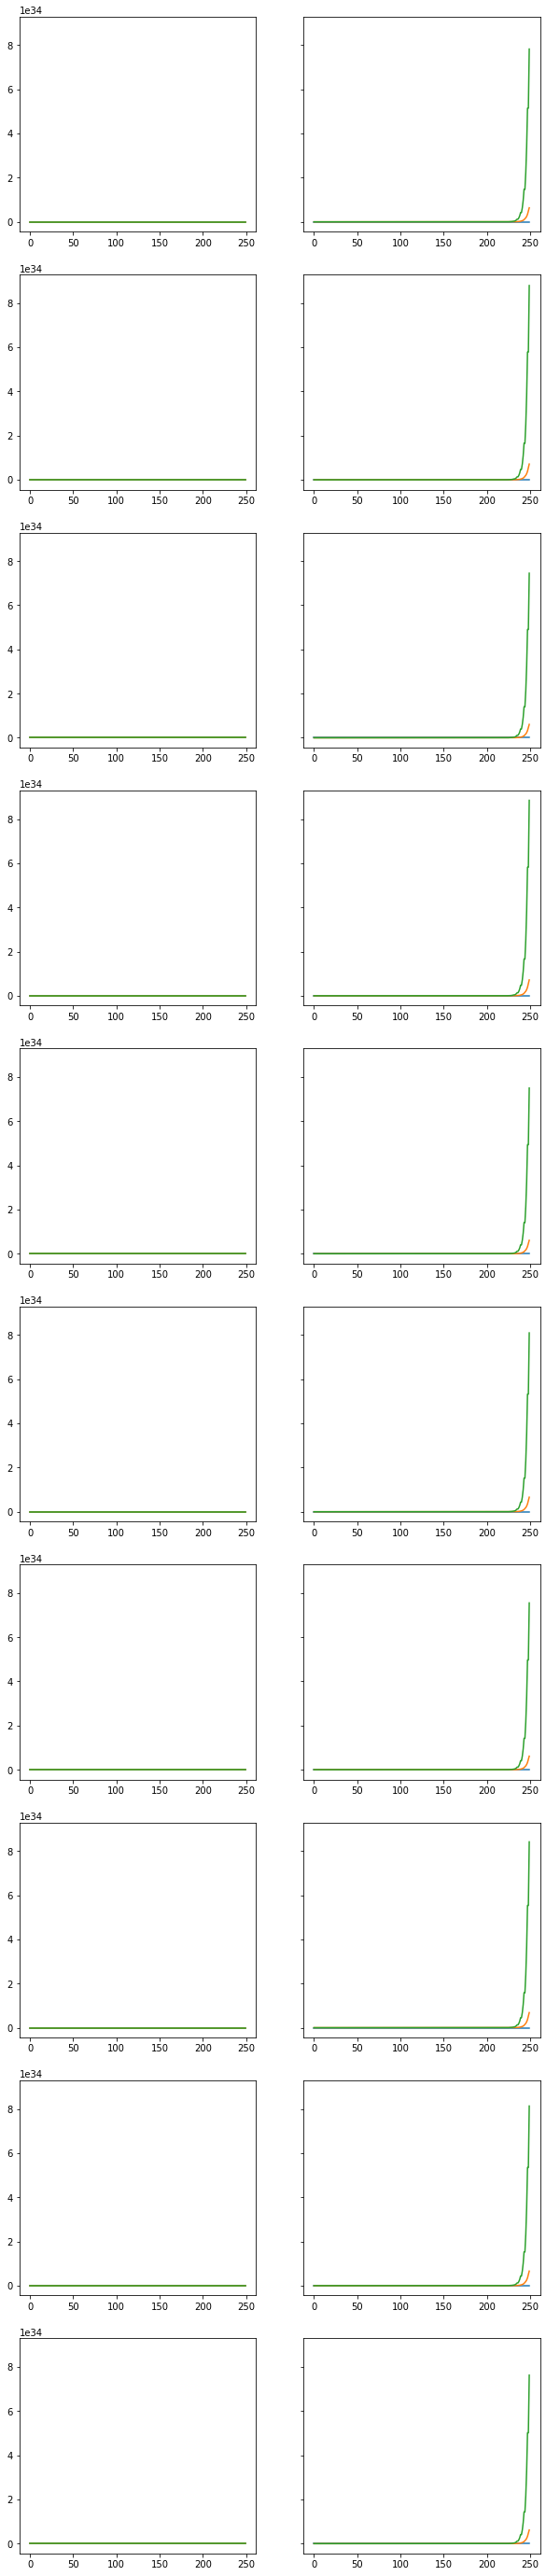

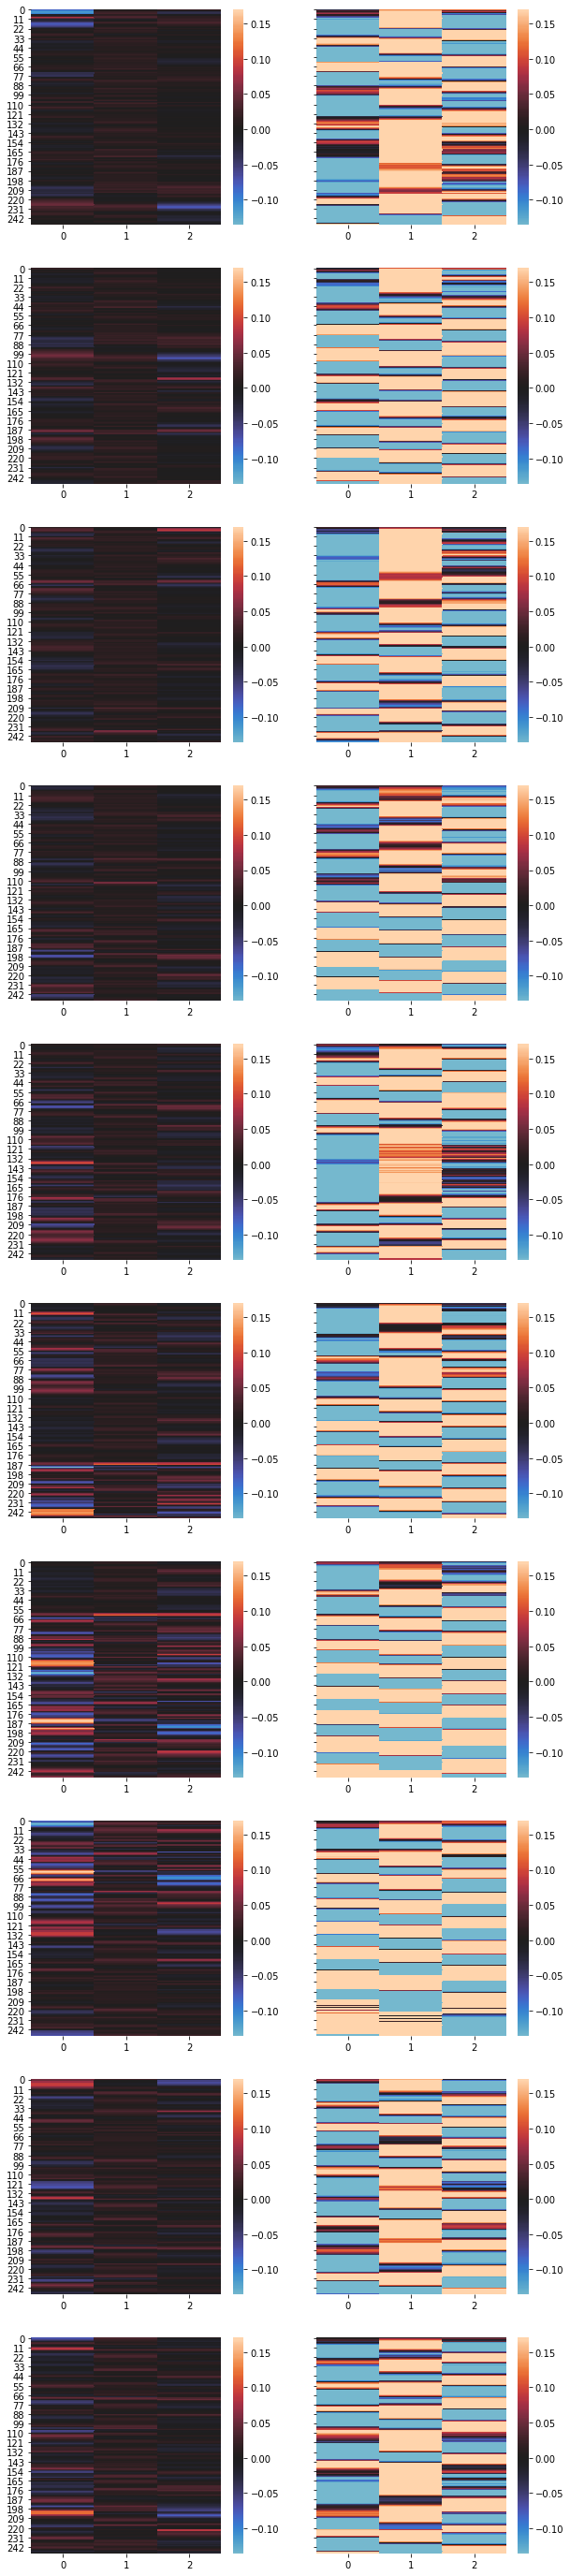

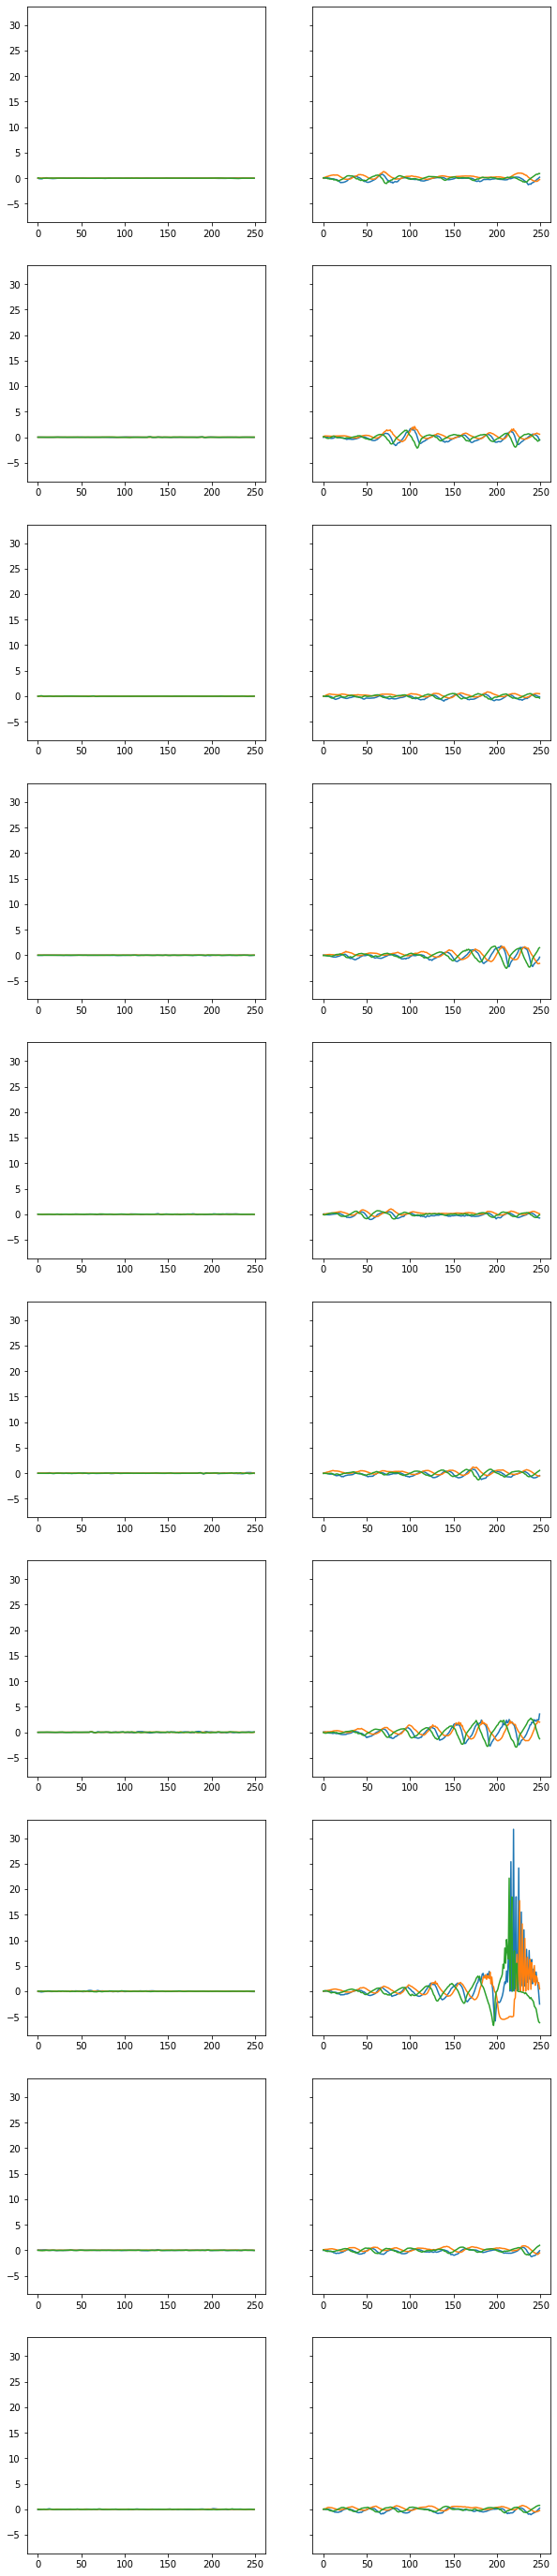

In [34]:
for small in [True, False]:
    for latent_dim in [32, 64, 128, 256, 512]:
        for act_id in range(0,3):
            x_train_activity, _ = filter_by_activity_index(x=x_train, y=y_train, activity_idx=act_id)

            
            input_shape = x_train[0].shape
            discriminator = create_discriminator(input_shape);
            generator = create_generator(latent_dim, small=small)
            optimizer = Adam(clipvalue=1.0, decay=1e-8)
            gan = create_gan(generator_model=generator, discriminator_model=discriminator, optimizer=optimizer)

            train_gan(generator, discriminator, gan, x_train_activity, steps)
            random_latent_vectors = np.random.normal(size=(num_gen, latent_dim))
            generated_sensor_data = generator.predict(random_latent_vectors)

            gen_df = pd.DataFrame(np.array([ts.transpose() for ts in generated_sensor_data]).tolist(), columns= ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'])
            gen_df['userAcceleration.c'] = calc_consultant(gen_df)
            gen_df['act'] = act_id

            gen_windowed_df = windowing_dataframe(gen_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

            input_cols = ['userAcceleration.c']
            x_gen, y_gen = transform_windows_df(gen_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
            x_gen = x_gen.reshape((len(x_gen), window_size))

            x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
            y_train_gen = np.concatenate([y_train_clf, y_gen[:add_sample_num]])

            svm_clf = SVC()
            svm_clf.fit(x_train_gen, y_train_gen)

            y_train_head = svm_clf.predict(x_train_clf)
            train_acc = accuracy_score(y_train_clf, y_train_head)

            y_test_head = svm_clf.predict(x_test_clf)
            test_acc = accuracy_score(y_test_clf, y_test_head)

            plot_n_heatmaps(x_train_activity, generated_sensor_data, n=10, save_dir='out/lstm_steps-{}_latentdim-{}_small-{}_actId-{}'.format(steps, latent_dim, small, act_id))
            plot_n_lineplots(x_train_activity, generated_sensor_data, n=10, save_dir='out/lstm_steps-{}_latentdim-{}_small-{}_actId-{}'.format(steps, latent_dim, small, act_id))

            file = open('out/lstm_steps-{}_latentdim-{}_small-{}_actId-{}/acc.txt'.format(steps, latent_dim, small, act_id), 'w+')
            file.write(f'Gen Train acc: {train_acc} vs. {orig_train_acc} :Orig Train Acc  \n')
            file.write(f'Gen Test acc: {test_acc} vs. {orig_test_acc} :Orig Test Acc')
            file.close()